In [2]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"):
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

xn, xx, yn, yx = [125,146,30,46]  # larger region for data retrieval
xn, xx, yn, yx = [125,133,30,40]  # smaller region for plotting

mapproj = cartopy.crs.PlateCarree()

In [2]:
sf_korea = gpd.read_file("sf_korea")
sf_ekorea = gpd.read_file("sf_ekorea")
sf_kyushu = gpd.read_file("sf_kyushu")

# Figures for comms

## HDWI anomaly & locations of fires

In [46]:
hdwi = xr.open_dataset("data/era5land/hdwi-from-vpdmax_era5land_195001-202503.nc").hdwi
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])

rm = regionmask.mask_geopandas(sf_korea, hdwi.longitude, hdwi.latitude)

In [47]:
ts = hdwi.where(rm == 0, drop = True).mean(["latitude", "longitude"])

In [48]:
ts_clim = ts.sel(time = slice("1990","2020")).groupby("time.month")[3].mean("time")
ts_ev = ts.rolling(time = 5).mean().sel(time = "2025").max()

ts_anom = (ts_ev - ts_clim).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 mean")
ts_relanom = ((ts_anom / ts_clim) * 100).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 mean (%)")

In [49]:
# date on hdwi5x ends
event_end = ts.rolling(time = 5).mean().sel(time = "2025").idxmax()

In [50]:
# use March climate as baseline
hdwi_clim = hdwi.sel(time = slice("1990","2020")).groupby("time.month")[3].mean("time")
hdwi_ev = hdwi.rolling(time = 5).mean().sel(time = event_end)

hdwi_anom = (hdwi_ev - hdwi_clim).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 mean", units = None)
hdwi_relanom = ((hdwi_anom / hdwi_clim) * 100).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 mean", units = "%")

In [51]:
# # use last ten days of March as baseline
# hdwi_clim = hdwi.sel(time = hdwi.time.dt.dayofyear.isin(range(81,92))).sel(time = slice("1990","2020")).mean("time")
# hdwi_ev = hdwi.rolling(time = 5).mean().sel(time = event_end)

# hdwi_anom = (hdwi_ev - hdwi_clim).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 mean for last 10 days of March", units = None)
# hdwi_relanom = ((hdwi_anom / hdwi_clim) * 100).assign_attrs(long_name = "HDWI anomaly wrt 1990-2020 for last 10 days of March", units = "%")

In [52]:
hdwi_relanom.reset_coords(drop = True).to_netcdf("hdwi-anomaly-for-event-map.nc")

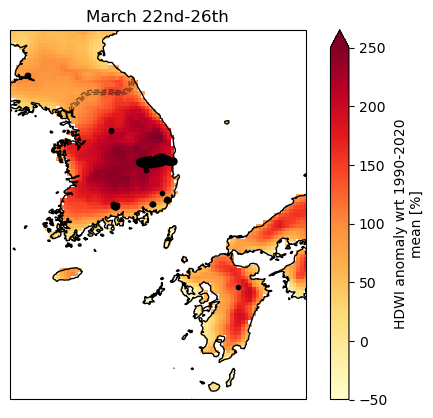

In [53]:
fig = hdwi_relanom.plot(subplot_kws = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]},
                        vmin = -50, vmax = 250, cmap = "YlOrRd")
ax = fig.axes

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
# sf_ekorea.boundary.plot(ax = ax, color = "darkblue", lw = 1)
ax.set_title("March 22nd-26th")

px_m = px.loc[slice("2025-03-22", "2025-03-26")]
ax.scatter(px_m.longitude, px_m.latitude, color = "k", marker = ".")

In [54]:
px_m.to_csv("active-fires-for-event-map.csv")

## 2025 burned area

In [21]:
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(x=px.longitude, y=px.latitude), crs = mapproj).clip(sf_korea.set_crs(mapproj))

In [22]:
n_px = px[["geometry"]].groupby(px.index).count()

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


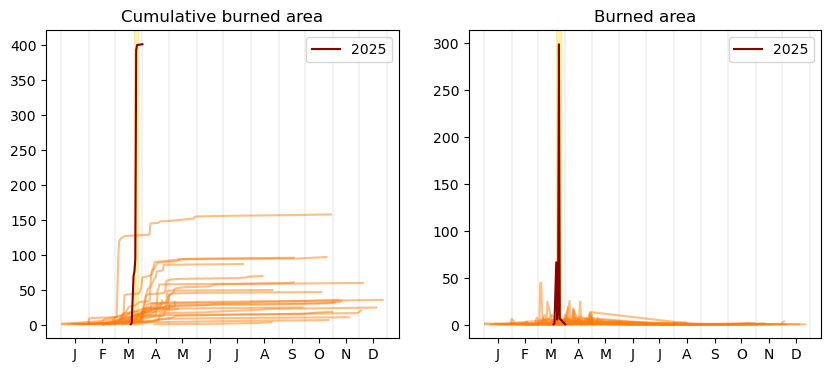

In [26]:
fig, axs = plt.subplots(ncols = 2, figsize = (2*5, 4), dpi = 100)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0]
for y in range(2001,2025):
    ts_y = n_px.loc[str(y)].cumsum()
    ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
y = 2025; ts_y = n_px.loc[str(y)].cumsum(); ax.plot(ts_y.index.dayofyear, ts_y, color = "darkred", alpha = 1, label = "2025")
ax.legend()
ax.set_title("Cumulative burned area")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]
for y in range(2001,2025):
    ts_y = n_px.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
y = 2025; ts_y = n_px.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y, color = "darkred", alpha = 1, label = "2025")
ax.legend()
ax.set_title("Burned area")

for ax in axs:
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    d_start = n_px.loc[["2025-03-22"]].index.dayofyear.values
    ax.add_patch(Rectangle((d_start, 0), 5, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

## Overlay HDWI & precip

In [76]:
pr = xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").pr
hdwi = xr.open_dataset("daily-ts/hdwi-from-vpdmax_era5land_195001-202503_kr.nc").hdwi

In [77]:
pr25 = pr.sel(time = "2025")
hdwi25 = hdwi.sel(time = "2025")

In [78]:
pr_sc = pr.rolling(time = 15, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
hdwi_sc = hdwi.rolling(time = 15, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
px_sc = n_px[["geometry"]].groupby(n_px.index.dayofyear).count()

Text(0, 0.5, 'HDWI')

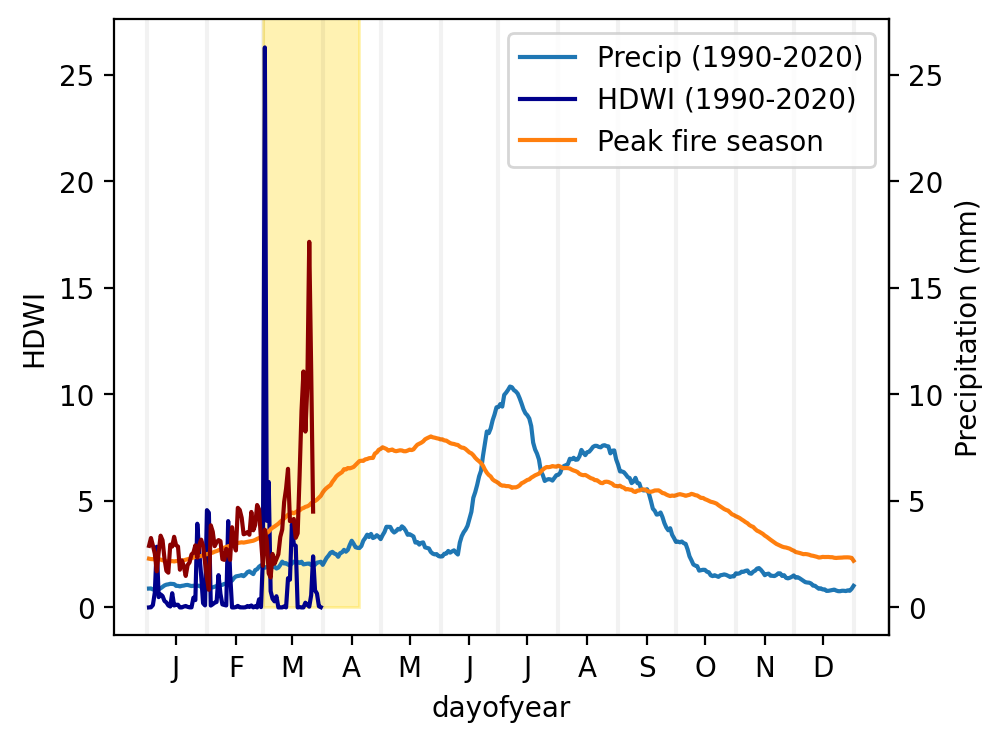

In [80]:
fig, ax = plt.subplots(figsize = (5,4), dpi = 200)

pr_sc.plot(ax = ax, color = "tab:blue", label = "Precip")
secax = ax.secondary_yaxis('right')
secax.set_ylabel('Precipitation (mm)')

ax.plot(pr25.time.dt.dayofyear, pr25, color = "darkblue")

hdwi_sc.plot(ax = ax, color = "tab:orange", label = "HDWI")
ax.plot(hdwi25.time.dt.dayofyear, hdwi25, color = "darkred")

ylim = ax.get_ylim()
d_start = pr.sel(time = "2025-03-01").time.dt.dayofyear.values
# px_sc.plot(ax = ax, color = "firebrick", label = "Fire activity 2001-2024")

ax.add_patch(Rectangle((d_start, 0), 50, ylim[1]+10, color = "gold", alpha = 0.3))
ax.set_ylim(ylim)

# ax.legend(["Precip (1990-2020)", "Precip 2025", "HDWI (1990-2020)", "HDWI 2025", "Peak fire season"])
ax.legend(["Precip (1990-2020)", "HDWI (1990-2020)", "Peak fire season"])

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ax.set_ylabel("HDWI")

In [75]:
fig, ax = plt.subplots(figsize = (5,4), dpi = 100)

pr_sc.plot(ax = ax, color = "tab:blue", label = "Precip")
secax = ax.secondary_yaxis('right')
secax.set_ylabel('Precipitation (mm)')

ax.plot(pr25.time.dt.dayofyear, pr25, color = "darkblue")

hdwi_sc.plot(ax = ax, color = "tab:orange", label = "HDWI")
ax.plot(hdwi25.time.dt.dayofyear, hdwi25, color = "darkred")

ylim = ax.get_ylim()
d_start = pr.sel(time = "2025-03-01").time.dt.dayofyear.values
# px_sc.plot(ax = ax, color = "firebrick", label = "Fire activity 2001-2024")

ax.add_patch(Rectangle((d_start, 0), 50, ylim[1]+10, color = "gold", alpha = 0.3))
ax.set_ylim(ylim)

# ax.legend(["Precip (1990-2020)", "Precip 2025", "HDWI (1990-2020)", "HDWI 2025", "Peak fire season"])
ax.legend(["Precip (1990-2020)", "HDWI (1990-2020)", "Peak fire season"])

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ax.set_ylabel("HDWI")

# Final figure

In [4]:
hdwi = xr.open_dataset("daily-ts/hdwi-from-vpdmax_era5land_195001-202503_kr.nc").hdwi
# hdwi = hdwi.assign_coords(offset_time = ("time", hdwi.time.shift(time = 0).data)) # shift time if seasonal cycle needs to be moved

pr = xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").pr
# pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data)) # shift time if seasonal cycle needs to be moved

In [6]:
hdwi5 = hdwi.rolling(time = 5).mean()
pr5 = pr.rolling(time = 5).mean()

In [ ]:
hdwi5.to_netcdf("data/hdwi5.nc")

In [8]:
pr5.to_netcdf("data/pr5.nc")

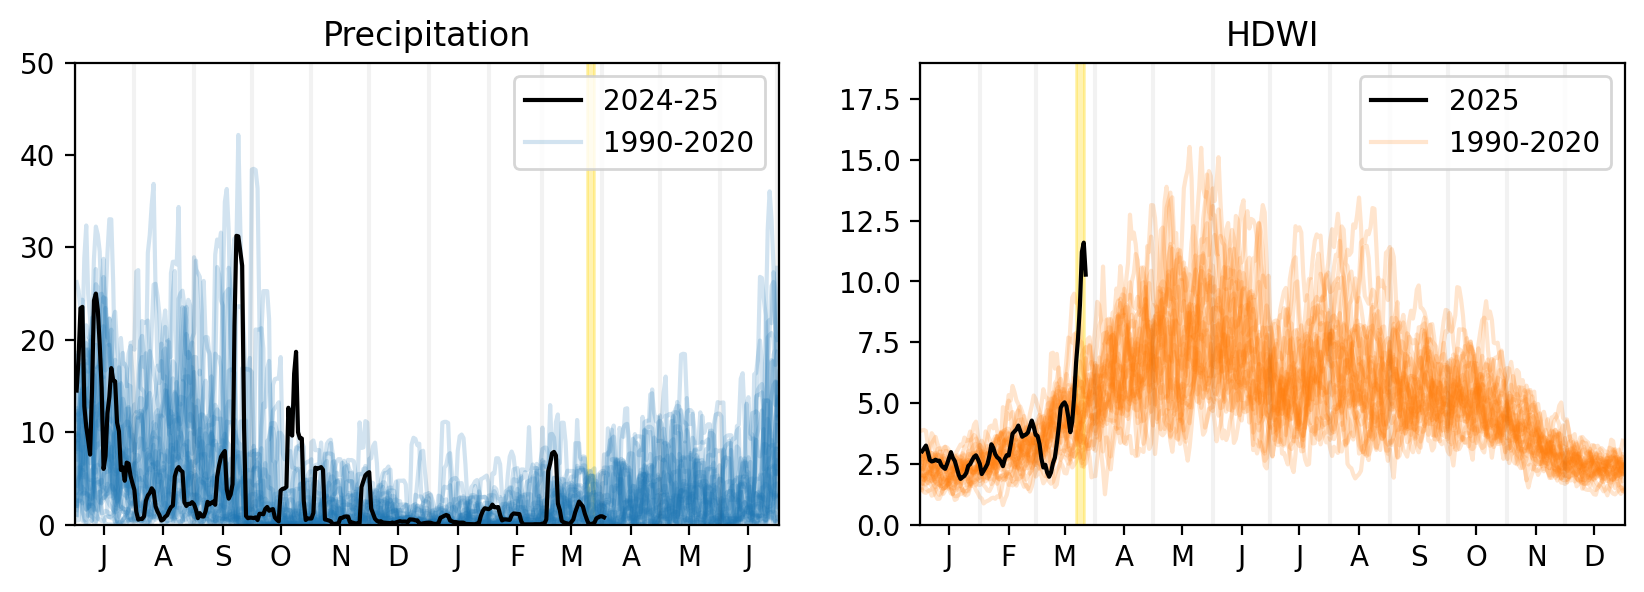

In [3]:
nc = 2; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 200, sharex = False)
plt.subplots_adjust(hspace = 0.25)

for i in range(2):
    ax = axs.flatten()[i]
    ts = [pr, hdwi][i]
    nd = [5,5][i]
    ts = ts.rolling(time = nd).mean()
    col = ["tab:blue", "tab:orange"][i]
    
    if i == 0:
        ylim = [0,50]
        days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
        labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
        labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]
    else:
        ylim = [0,19]
        days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
        labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
        labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]
    
    y = [2024,2025][i]; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-25", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = col, alpha = 0.2, label = "_years")
    
    ax.legend([["2024-25", "2025"][i], "1990-2020"], loc = "upper right")
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
    
#     ylim = ax.get_ylim()
    d_start = ts.sel(time = "2025-03-22").offset_time.dt.dayofyear
    ax.add_patch(Rectangle((d_start, 0), 4, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    ax.margins(x = 0)
    
    ax.set_title(["Precipitation", "HDWI"][i])


## Temp vs windspeed

In [3]:
pr = xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").pr
hdwi = xr.open_dataset("daily-ts/hdwi-from-vpdmax_era5land_195001-202503_kr.nc").hdwi
wspd = xr.open_dataset("daily-ts/sfcWindmax_era5land_195001-202503_kr.nc").sfcWindmax
tasmax = xr.open_dataset("daily-ts/tasmax_era5land_195001-202503_kr.nc").tasmax

In [4]:
hdwi, wspd, tasmax = [ds.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max() for ds in [hdwi, wspd, tasmax]]

In [5]:
pr = pr.sel(time = pr.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()

Text(0, 0.5, 'Feb-March total precip')

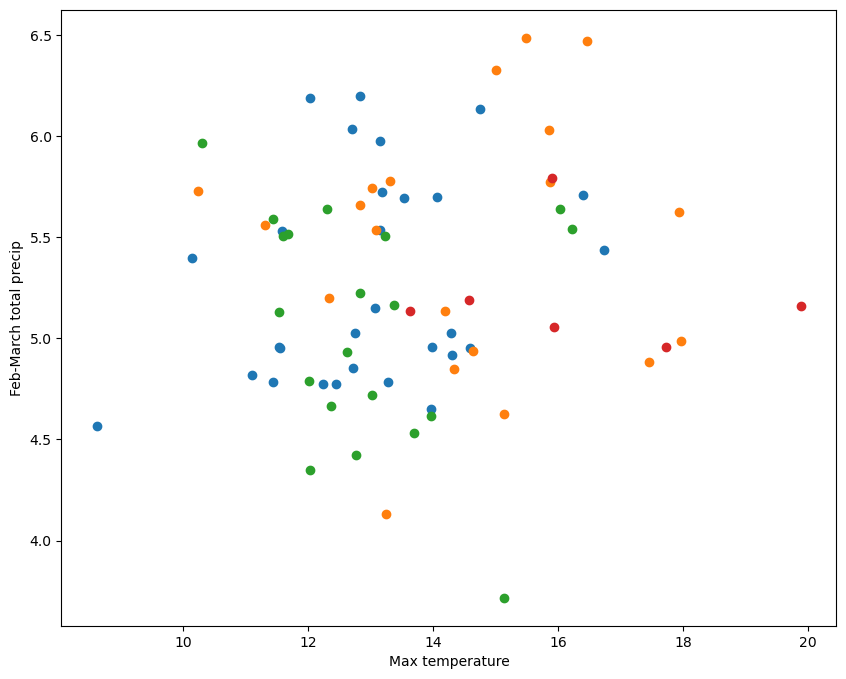

In [18]:
fig, ax = plt.subplots(figsize = (10,8))
for sl, col in zip([slice("1950","1979"), slice("1980","1999"), slice("2000","2019"), slice("2020","2025")], ["tab:blue", "tab:green", "tab:orange", "tab:red"]):
    ax.scatter(tasmax.sel(time = sl), wspd.sel(time = sl), marker = "o", color = col)
    
ax.set_xlabel("Max temperature")
ax.set_ylabel("Feb-March total precip")

# Map of station locations

In [126]:
stn = pd.read_csv("station-metadata.csv", index_col = 0)
stn = stn.iloc[1:]

In [135]:
df = pd.read_csv("res-stn_hdwi_kr.csv", index_col = 0)
df.index = [int(s[-3:]) for s in df.index]

In [137]:
df = pd.merge(df, stn, left_index = True, right_index = True)

In [147]:
df

,mu0_est,mu0_lower,mu0_upper,sigma0_est,sigma0_lower,sigma0_upper,alpha-gmst_est,alpha-gmst_lower,alpha-gmst_upper,shape_est,...,dI-abs_upper,dI-rel_est,dI-rel_lower,dI-rel_upper,aic_est,aic_lower,aic_upper,stn_name,lat,lon
130,16.309045,14.565661,17.868345,3.759955,2.712469,4.557549,-0.650477,-3.449111,2.405661,0.036466,...,3.130216,-3.545505,-16.266563,15.750724,323.900317,289.176234,343.901586,Uljin,36.99176,129.41278
136,10.970296,9.871640,12.232715,2.415451,1.691617,2.926989,2.342802,0.719834,4.129595,0.059543,...,5.417993,11.027080,3.467240,21.460220,251.919934,220.628045,273.779452,Andong,36.57293,128.70733
138,14.155650,12.821857,15.409368,3.468238,2.756092,4.057398,0.626514,-1.410763,2.706433,0.051145,...,3.521548,2.621480,-5.292477,12.417029,447.342365,411.724954,470.902898,Pohang,36.03201,129.38002
271,6.421919,3.821241,8.278345,2.878076,1.356730,3.903498,4.776273,2.040606,8.847029,-0.272081,...,10.101627,45.320441,15.422536,102.993574,193.736901,151.282573,211.347792,Bonghwa,36.94361,128.91449
272,12.793213,10.970413,14.750280,3.139714,2.436954,3.640225,4.098356,1.315473,6.643422,-0.027342,...,8.604549,20.064664,5.651619,36.966297,294.369440,264.575450,313.645269,Yeongju,36.87183,128.51687
273,9.949578,8.783981,11.391363,2.431647,1.916895,2.839688,3.706568,1.813415,5.751328,-0.038695,...,7.796105,21.700569,9.445251,40.547493,266.265088,233.941863,285.414351,Mungyeong,36.62727,128.14879
277,9.049303,7.322683,10.834269,3.644675,2.636007,4.515585,9.970655,7.672971,12.417727,0.219068,...,16.143045,50.815695,35.006301,72.305795,325.874145,292.129016,349.626939,Yeongdeok,36.53336,129.40924
278,9.071752,8.029086,10.232040,2.364431,1.720036,2.862745,3.462551,1.932165,5.171712,0.106638,...,6.723309,19.211083,9.805306,31.700500,272.959382,242.368525,295.373583,Uiseong,36.35610,128.68862
279,13.752132,12.085696,15.406570,3.065164,2.140608,3.689660,-2.944337,-5.290306,-0.790503,-0.029040,...,-1.005763,-13.049198,-20.849680,-3.793827,291.803739,260.893732,310.635313,Gumi,36.13055,128.32055
281,11.095320,9.757032,12.406706,2.688303,1.712608,3.253370,3.401101,1.729406,5.264010,-0.051050,...,6.844915,19.584208,9.482155,33.964699,276.688983,242.956295,296.077958,Yeongcheon,35.97742,128.95140


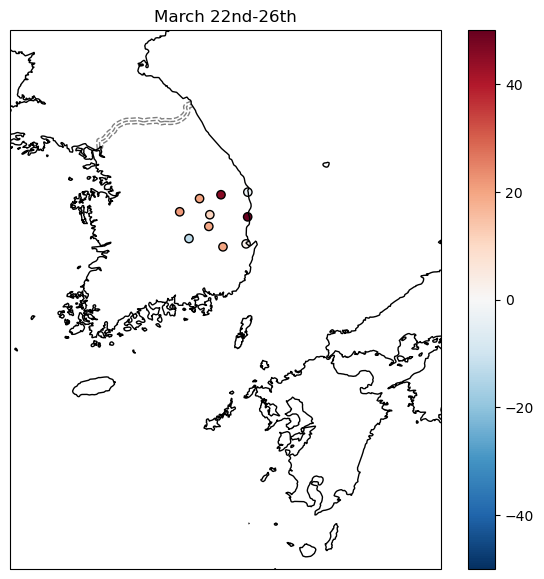

In [145]:
fig, ax = plt.subplots(dpi = 100, figsize = (7,7), subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})

# hdwi_relanom.plot(ax = ax, vmin = -50, vmax = 250, cmap = "YlOrRd")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
# sf_ekorea.boundary.plot(ax = ax, color = "darkblue", lw = 1)
ax.set_title("March 22nd-26th")
cbar = ax.scatter(df.lon, df.lat, marker = "o", edgecolor = "k", c = df["dI-rel_est"], vmin = -50, vmax = 50, cmap = "RdBu_r")
plt.colorbar(cbar)

# Figures for report

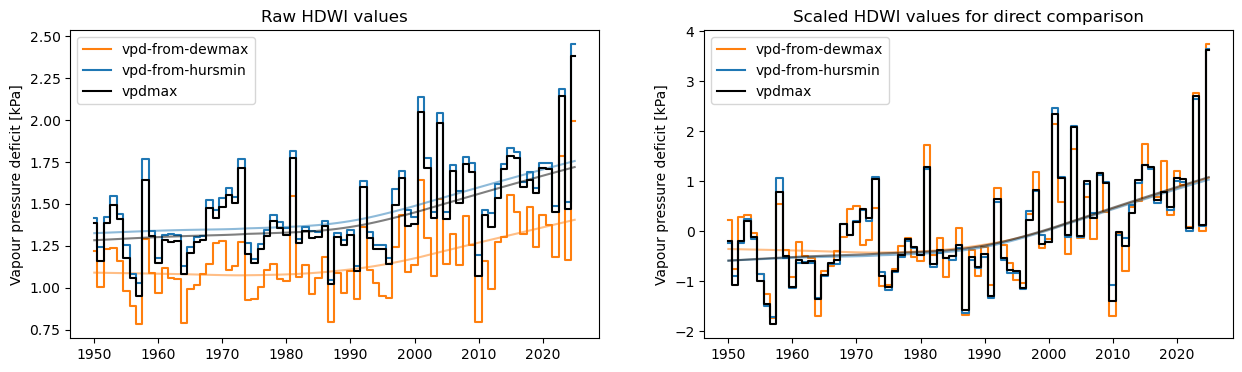

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 4), dpi = 100)
   
fl = [fnm for fnm in sorted(glob.glob("daily-ts/vpd*"+rnm+".nc")) if not "monthly" in fnm]
for fnm in fl:
    ts = xr.open_dataset(fnm)
    ts = ts[list(ts.data_vars)[0]]
    
    varnm = fnm.split("/")[-1].split("_")[0]
    col = {"vpdmax" : "k", "vpd-from-hursmin" : "tab:blue", "vpd-from-dewmax" : "tab:orange", "vpd-from-monthly" : "tab:green"}[varnm]
    
    vpd5x = ts.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max().dropna("time", "any")
    vpd5x = vpd5x.assign_coords(time = vpd5x.time.dt.year).rename(time = "year")
    
    vpd5x.plot(ax = axs[0], drawstyle = "steps-mid", label = varnm, color = col)
    axs[0].plot(vpd5x.year.values, lowess(vpd5x.values, vpd5x.year.values)[:,1], color = col, alpha = 0.5)
    
    scale(vpd5x).plot(ax = axs[1], drawstyle = "steps-mid", color = col, label = varnm)
    axs[1].plot(vpd5x.year.values, lowess(scale(vpd5x).values, vpd5x.year.values)[:,1], color = col, alpha = 0.5)
    

for ax in axs:
    ax.set_xlabel(""); ax.legend()

axs[0].set_title("Raw HDWI values")
axs[1].set_title("Scaled HDWI values for direct comparison")

plt.savefig("fig/compare-vpd-methods_"+rnm+".png")